# Questions and hypothesis

We proceed to analyse here the main three topics in the project. For this, we will formulate three questions:

- What is the market size for each country?
- Does population size affect the market size/consumption and how strong is the correlation?
- Is chocolate consumption affected by bad weather or holiday?

## What is the market size for each country?

To answer this question, we will build graph with data of total consumption per country, represented via both sales and units sold.


In [2]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sns
from dotenv import load_dotenv, dotenv_values
import os
import matplotlib.pyplot as plt


from sqlalchemy import create_engine, types
from sqlalchemy import text # to be able to pass string
from sqlalchemy import Integer, String, Float, DateTime, Date

# Loading values from .env
config = dotenv_values()

# Define variables for the login
load_dotenv()
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
dbname = os.getenv("DB_NAME")
schema = os.getenv("DB_SCHEMA")

# PostgreSQL URL creation
url = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'

# Create engine
engine = create_engine(url)


In [3]:
# Load table of sales
with engine.connect() as conn:
    conn.execute(text(f"SET search_path TO {schema}"))
    sales = pd.read_sql(
        text("SELECT * FROM jl_sales"),
        conn
    )

In [4]:
print(sales.head())
print('=================================================================================================================================================')
print(sales.describe())

     Sales Person    Country              Product        Date   Amount  \
0  Jehu Rudeforth         UK      Mint Chip Choco  2022-01-04   5320.0   
1     Van Tuxwell      India        85% Dark Bars  2022-08-01   7896.0   
2    Gigi Bohling      India  Peanut Butter Cubes  2022-07-07   4501.0   
3    Jan Morforth  Australia  Peanut Butter Cubes  2022-04-27  12726.0   
4  Jehu Rudeforth         UK  Peanut Butter Cubes  2022-02-24  13685.0   

   Boxes Shipped  Year  Month  
0            180  2022      1  
1             94  2022      8  
2             91  2022      7  
3            342  2022      4  
4            184  2022      2  
             Amount  Boxes Shipped         Year        Month
count   3282.000000    3282.000000  3282.000000  3282.000000
mean    6030.338775     164.666971  2023.000000     4.576782
std     4393.980200     124.024736     0.816621     2.315759
min        7.000000       1.000000  2022.000000     1.000000
25%     2521.495000      71.000000  2022.000000     3.0000

In [5]:
sales.groupby("Country")["Amount"].sum().sort_values()



Country
New Zealand    3043654.04
Canada         3078495.65
USA            3313858.09
India          3343730.83
UK             3365388.90
Australia      3646444.35
Name: Amount, dtype: float64

In [6]:
sales.groupby("Country")["Boxes Shipped"].sum().sort_values()

Country
New Zealand    81350
USA            81820
India          89968
UK             92523
Canada         95158
Australia      99618
Name: Boxes Shipped, dtype: int64

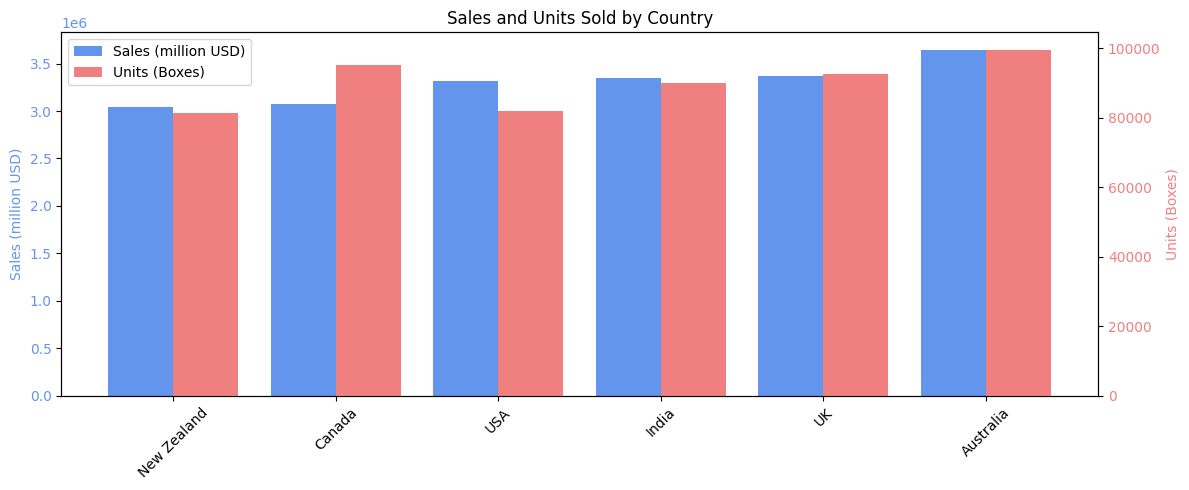

In [27]:
# Graph to display these results

# Aggregate once
country_data = (
    sales.groupby("Country")[["Amount", "Boxes Shipped"]]
         .sum()
         .sort_values("Amount")
)

countries = country_data.index
x = np.arange(len(countries))
width = 0.4

# Create figure
fig, ax1 = plt.subplots(figsize=(12, 5))

# --- Sales (left y-axis) ---
bars1 = ax1.bar(
    x - width/2,
    country_data["Amount"],
    width,
    color="cornflowerblue",
    label="Sales (million USD)"
)

ax1.set_ylabel("Sales (million USD)", color="cornflowerblue")
ax1.tick_params(axis='y', labelcolor="cornflowerblue")

# --- Units (right y-axis) ---
ax2 = ax1.twinx()

bars2 = ax2.bar(
    x + width/2,
    country_data["Boxes Shipped"],
    width,
    color="lightcoral",
    label="Units (Boxes)"
)

ax2.set_ylabel("Units (Boxes)", color="lightcoral")
ax2.tick_params(axis='y', labelcolor="lightcoral")

# --- X-axis formatting ---
ax1.set_xticks(x)
ax1.set_xticklabels(countries, rotation=45)

# --- Title ---
plt.title("Sales and Units Sold by Country")

# --- Combined legend ---
bars = bars1 + bars2
labels = [bar.get_label() for bar in [bars1, bars2]]
ax1.legend([bars1, bars2], labels, loc="upper left")

plt.tight_layout()
plt.show()



We can clearly see here that Australia is the first country in both sales and consumption of the chocolate products, whereas New Zealand has the last position. The rest of countries have different positions and do not display, at this very first approach, a clear position within the global market.

Also, we need to have in mind these are total figures, so a further analysis based on the size of the country is needed to ponderate the market variables.

## Does population size affect the market size/consumption and how strong is the correlation?

We will now add the population size data to the analysis, by loading it from the database. Sales and units sold by country will be pondered by population.

In [8]:
# Load table of sales
with engine.connect() as conn:
    conn.execute(text(f"SET search_path TO {schema}"))
    population = pd.read_sql(
        text("SELECT * FROM jl_pop_22_25_second"),
        conn
    )

# Delete 2025 population data (NaN)
population = population[population["Year"] != 2025]

population.head(5)

,Country Name,Country Code,Year,Population
0,Australia,AUS,2022,26018721.0
1,Australia,AUS,2023,26659922.0
2,Australia,AUS,2024,27196812.0
4,Canada,CAN,2022,38935934.0
5,Canada,CAN,2023,40083484.0


In [ ]:
# Create sales per year and country

sales_usd = sales.groupby(["Country", "Year"])[["Amount"]].sum().reset_index()
sales_boxes = sales.groupby(["Country", "Year"])[["Boxes Shipped"]].sum().reset_index()

# Join both sales

joined_sales = pd.merge(
    sales_usd,
    sales_boxes,
    on=["Country","Year"],
    how="inner"
)

# Mapping country names for exact match with population table
country_map = {
    "UK": "United Kingdom",
    "USA": "United States",
    "US": "United States"
}

# Name normalisation
joined_sales["Country_norm"] = joined_sales["Country"].replace(country_map)
population["Country_norm"] = population["Country Name"].replace(country_map)

# Merge por las columnas normalizadas
joined_salespop = pd.merge(
    joined_sales,
    population,
    on=["Country_norm", "Year"],
    how="outer"
)

# Fill NaN with 0
joined_salespop[["Amount", "Boxes"]] = joined_sales[["Amount", "Boxes Shipped"]].fillna(0)

# Drop column Country and other additional ones
joined_salespop.drop(columns=["Country", 'Country Code', 'Boxes', 'Country Name'], inplace=True)

# Rename column for Country
joined_salespop = joined_salespop.rename(columns={"Country_norm": "Country"})

# Reorder columns
joined_salespop = joined_salespop[["Country", "Year", "Amount", "Boxes Shipped", "Population"]]

# Calculate Amount per capita and Boxes per capita
joined_salespop['Amount_pc'] = joined_salespop['Amount'] / joined_salespop['Population']
joined_salespop['Boxes_pc'] = joined_salespop['Boxes Shipped'] / joined_salespop['Population']

joined_salespop.head()

,Country,Year,Amount,Boxes Shipped,Population,Amount_pc,Boxes_pc
0,Australia,2022,1137367.00,32647,26018721.0,0.043713,0.001255
1,Australia,2023,1227533.72,33459,26659922.0,0.046044,0.001255
2,Australia,2024,1281543.63,33512,27196812.0,0.047121,0.001232
3,Canada,2022,962899.00,31221,38935934.0,0.024730,0.000802
4,Canada,2023,1032494.68,32013,40083484.0,0.025759,0.000799


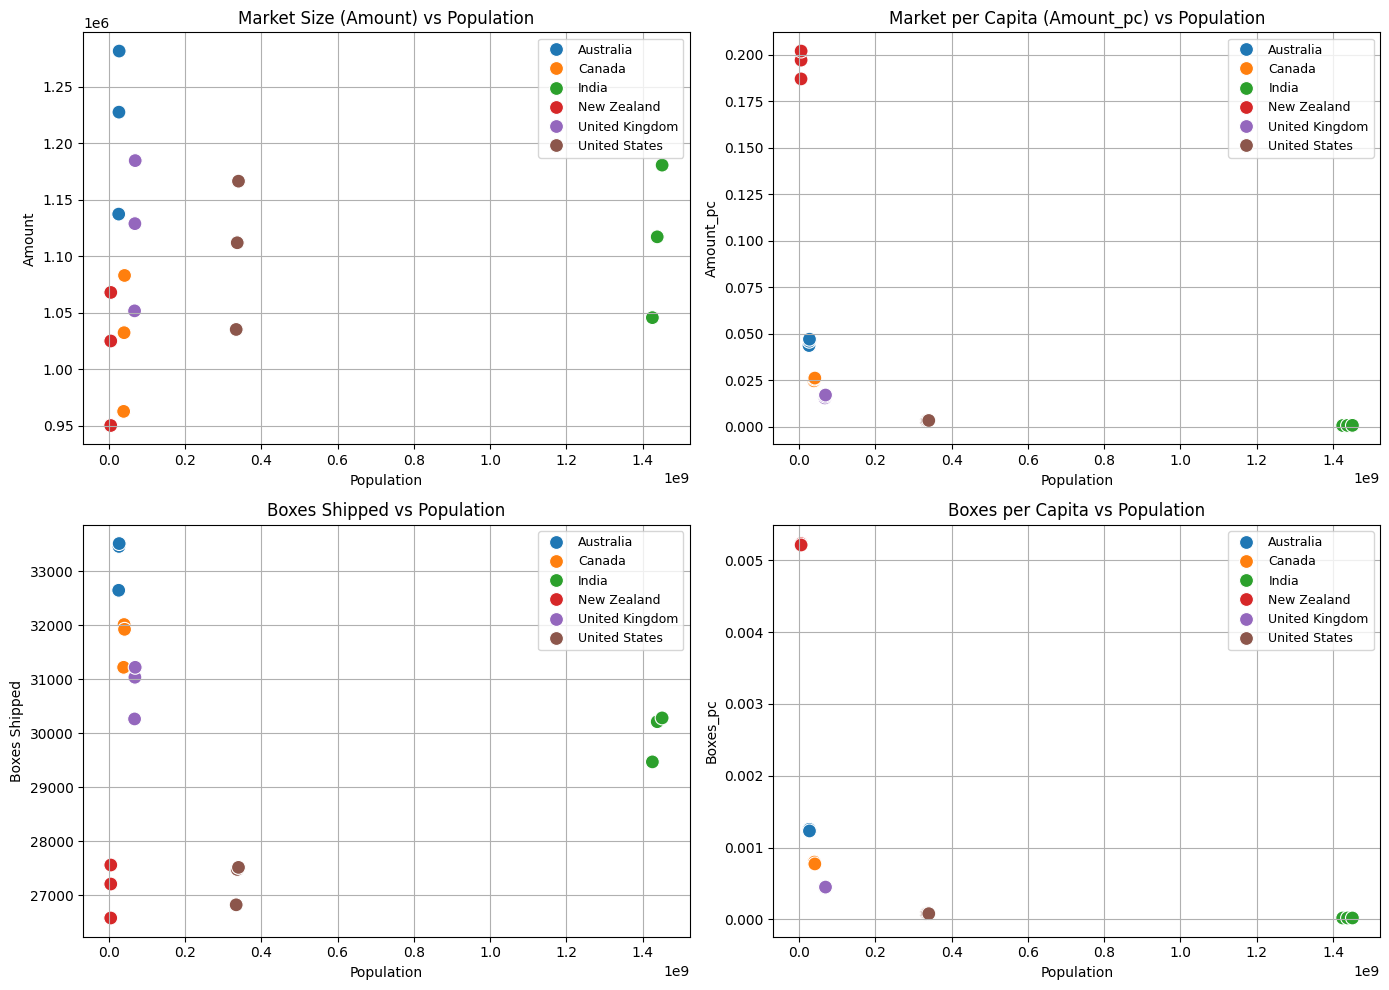

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Amount vs Population
sns.scatterplot(data=joined_salespop, x="Population", y="Amount", hue="Country", ax=axes[0,0], s=100)
axes[0,0].set_title("Market Size (Amount) vs Population")
axes[0,0].grid(True)

# Amount per capita vs Population
sns.scatterplot(data=joined_salespop, x="Population", y="Amount_pc", hue="Country", ax=axes[0,1], s=100)
axes[0,1].set_title("Market per Capita (Amount_pc) vs Population")
axes[0,1].grid(True)

# Boxes Shipped vs Population
sns.scatterplot(data=joined_salespop, x="Population", y="Boxes Shipped", hue="Country", ax=axes[1,0], s=100)
axes[1,0].set_title("Boxes Shipped vs Population")
axes[1,0].grid(True)

# Boxes per capita vs Population
sns.scatterplot(data=joined_salespop, x="Population", y="Boxes_pc", hue="Country", ax=axes[1,1], s=100)
axes[1,1].set_title("Boxes per Capita vs Population")
axes[1,1].grid(True)


for ax in axes.flatten():
    ax.legend(loc="best", fontsize=9)

plt.tight_layout()
plt.show()


In [29]:
# Correlation between population and sales
population_amount_corr = joined_salespop["Population"].corr(joined_salespop["Amount"])
population_boxes_corr = joined_salespop["Population"].corr(joined_salespop["Boxes Shipped"])

print(f"Correlation Population vs Amount: {population_amount_corr:.3f}")
print(f"Correlation Population vs Boxes Shipped: {population_boxes_corr:.3f}")


# Same correlation but per capita
population_amountpc_corr = joined_salespop["Population"].corr(joined_salespop["Amount_pc"])
population_boxspc_corr = joined_salespop["Population"].corr(joined_salespop["Boxes_pc"])

print(f"Correlation Population vs Amount per capita: {population_amountpc_corr:.3f}")
print(f"Correlation Population vs Boxes per capita: {population_boxspc_corr:.3f}")

Correlation Population vs Amount: 0.096
Correlation Population vs Boxes Shipped: -0.112
Correlation Population vs Amount per capita: -0.408
Correlation Population vs Boxes per capita: -0.417


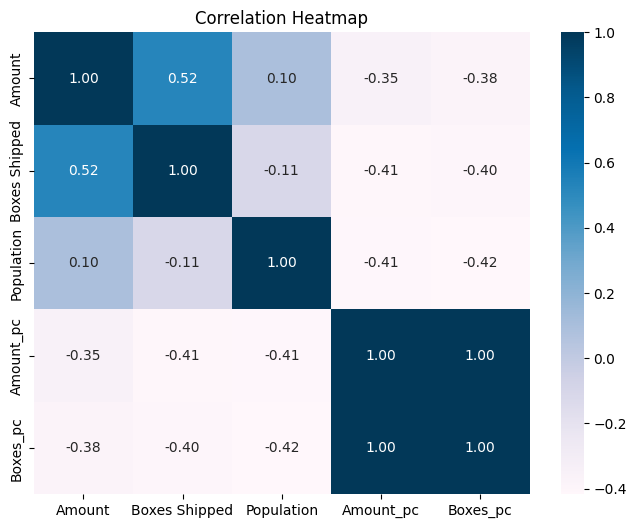

In [12]:
numeric_cols = ["Amount", "Boxes Shipped", "Population", "Amount_pc", "Boxes_pc"]

corr_matrix = joined_salespop[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="PuBu", cbar=True)
plt.title("Correlation Heatmap")
plt.show()



As a result, we have established and found:

- Higher correlation is found between amount in USD and boxes shipped, as expected.
- The size of the population has barely an effect on the size of the market. The correlations with Amount (0.096) and Boxes Shipped (-0.112) are rather weak, when not inverse.
- When the population is higher, per capita sales get reduced. Correlations are -0.408 and -0.417. This is clearly indicating larger countries will not necessarily consume more chocolate per person. The market size is not strongly determined by population.

## Is chocolate consumption affected by bad weather?

We believe the consumption of chocolate is affected by two variables: bad weather and holiday. When the weather is colder and rainy, chocolate consumptions is expected to increase. Additionally, during leisure times such as holidays a increase in the consumption of chocolate is to be expected.

### Weather: UK, NZ sales

Here we need to compare temperature and rainfall with sales. We will load the datasets accordingly and do an early graph.

In [13]:
# Load UK weather data

with engine.connect() as conn:
    conn.execute(text(f"SET search_path TO {schema}"))
    uk_weather = pd.read_sql(
        text("SELECT * FROM jl_uk_weather"),
        conn
    )

# Load NZ weather data

with engine.connect() as conn:
    conn.execute(text(f"SET search_path TO {schema}"))
    nz_temp = pd.read_sql(
        text("SELECT * FROM jl_nz_temp"),
        conn
    )

with engine.connect() as conn:
    conn.execute(text(f"SET search_path TO {schema}"))
    nz_rain = pd.read_sql(
        text("SELECT * FROM jl_nz_rain"),
        conn
    )

In [14]:
# Define new frame with NZ temperature and rainfall only per day

columns_to_exclude = ['1615','24120','41212','41382','5451']
nz_temp_drop = nz_temp.drop(columns=columns_to_exclude)
nz_rain_drop = nz_rain.drop(columns=columns_to_exclude)

# Merge NZ data tables

nz_weather = pd.merge(
    nz_temp_drop,
    nz_rain_drop,
    on="Date",
    how="inner"
)

In [15]:
# Load sales data

with engine.connect() as conn:
    conn.execute(text(f"SET search_path TO {schema}"))
    sales = pd.read_sql(
        text("SELECT * FROM jl_sales"),
        conn
    )

We have three dataframes loaded here:

- uk_weather

- nz_weather

- sales

In [16]:
# Create the dataset for weather vs. sales

# NZ

nz_weather_sales1 = pd.merge(
    nz_weather,
    sales,
    on="Date",
    how="inner"
)

nz_weather_sales = nz_weather_sales1[nz_weather_sales1['Country']=='New Zealand']


# UK

uk_weather_sales1 = pd.merge(
    uk_weather,
    sales,
    on="Date",
    how="inner"
)
uk_weather_sales = uk_weather_sales1[uk_weather_sales1['Country']=='UK']

print(nz_weather_sales.head(5))
print('=======================')
print(uk_weather_sales.head(5))

          Date  Daily mean C  Daily mean mm         Sales Person      Country  \
10  2022-01-04         20.78           0.00       Dotty Strutley  New Zealand   
17  2022-01-04         20.78           0.00  Dennison Crosswaite  New Zealand   
22  2022-01-05         19.85           0.00      Gunar Cockshoot  New Zealand   
32  2022-01-10         21.28           0.25       Curtice Advani  New Zealand   
34  2022-01-10         21.28           0.25         Gigi Bohling  New Zealand   

                 Product  Amount  Boxes Shipped  Year  Month  
10  Choco Coated Almonds  5733.0            348  2022      1  
17   Organic Choco Syrup   371.0            229  2022      1  
22          Almond Choco  5173.0            129  2022      1  
32   Spicy Special Slims  4074.0            469  2022      1  
34    Smooth Sliky Salty   700.0             97  2022      1  
          Date  avg_temp_uk  avg_rain_uk     Sales Person Country  \
1   2022-01-03         7.22         5.26   Camilla Castle      UK 

/var/folders/48/t16ql6px73b6z62z8gt27g7r0000gn/T/ipykernel_2665/1413342398.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nz_weather_sales['Date'] = pd.to_datetime(nz_weather_sales['Date']) # Make sure of the format for the date
/var/folders/48/t16ql6px73b6z62z8gt27g7r0000gn/T/ipykernel_2665/1413342398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_weather_sales['Date'] = pd.to_datetime(uk_weather_sales['Date']) # Make sure of the format for the date


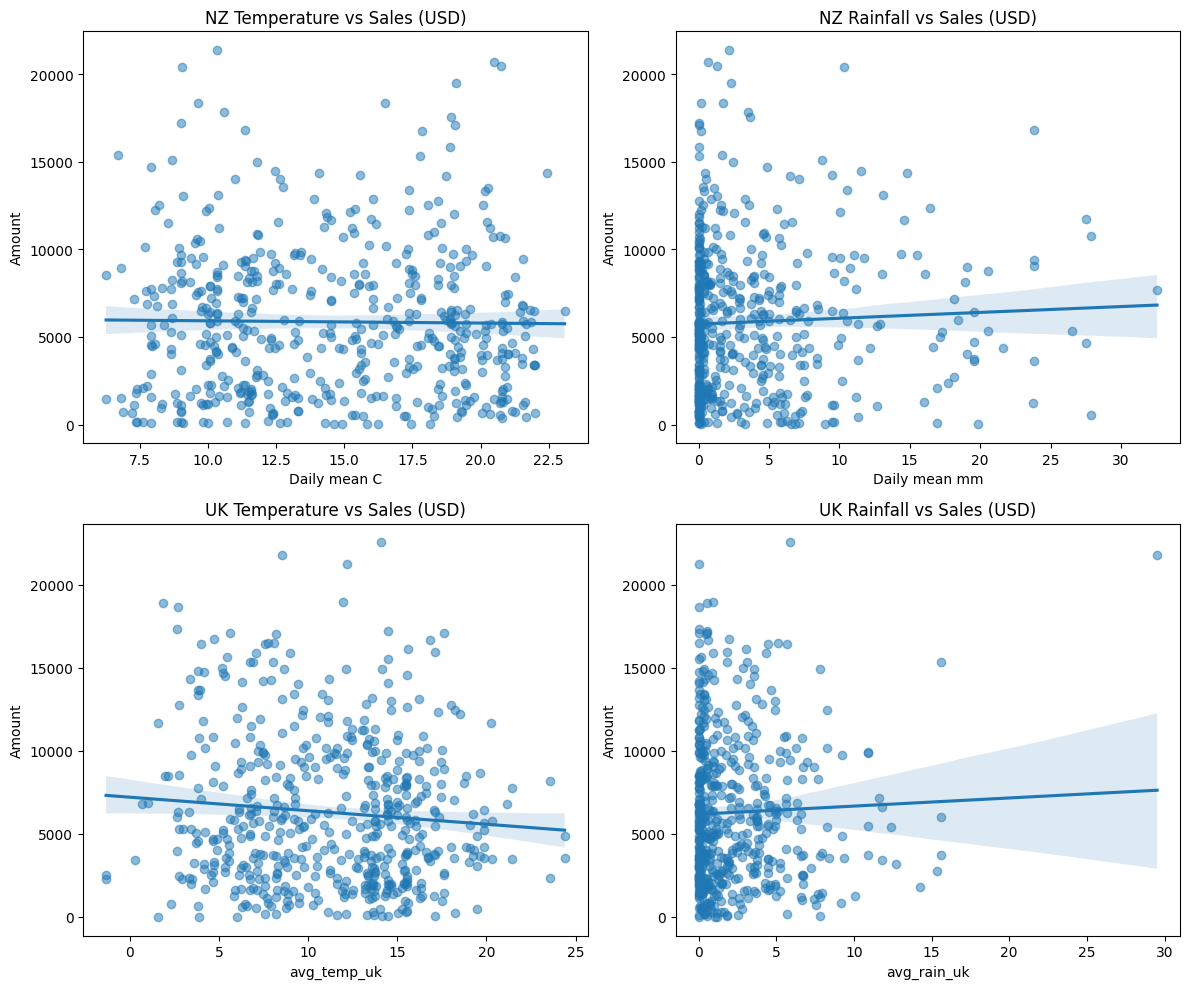

In [17]:
nz_weather_sales['Date'] = pd.to_datetime(nz_weather_sales['Date']) # Make sure of the format for the date
uk_weather_sales['Date'] = pd.to_datetime(uk_weather_sales['Date']) # Make sure of the format for the date


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- NZ Temperature ---
sns.regplot(
    data=nz_weather_sales,
    x='Daily mean C',
    y='Amount',
    scatter_kws={'alpha':0.5},
    ax=axes[0, 0]
)
axes[0, 0].set_title('NZ Temperature vs Sales (USD)')

# --- NZ Rainfall ---
sns.regplot(
    data=nz_weather_sales,
    x='Daily mean mm',
    y='Amount',
    scatter_kws={'alpha':0.5},
    ax=axes[0, 1]
)
axes[0, 1].set_title('NZ Rainfall vs Sales (USD)')

# --- UK Temperature ---
sns.regplot(
    data=uk_weather_sales,
    x='avg_temp_uk',
    y='Amount',
    scatter_kws={'alpha':0.5},
    ax=axes[1, 0]
)
axes[1, 0].set_title('UK Temperature vs Sales (USD)')

# --- UK Rainfall ---
sns.regplot(
    data=uk_weather_sales,
    x='avg_rain_uk',
    y='Amount',
    scatter_kws={'alpha':0.5},
    ax=axes[1, 1]
)
axes[1, 1].set_title('UK Rainfall vs Sales (USD)')

plt.tight_layout()
plt.show()


We can definitely see in the regression plots a light tendency to have more sales the lower the temperature and the higher the rainfall, especially for the UK dataset. This specifity for the UK, and the lightness of the tendency may be due to cultural differences, or because of a different taste for chocolate, as we saw in the exploratory data analysis. Let's analyse this using units instead of total amount of sales.

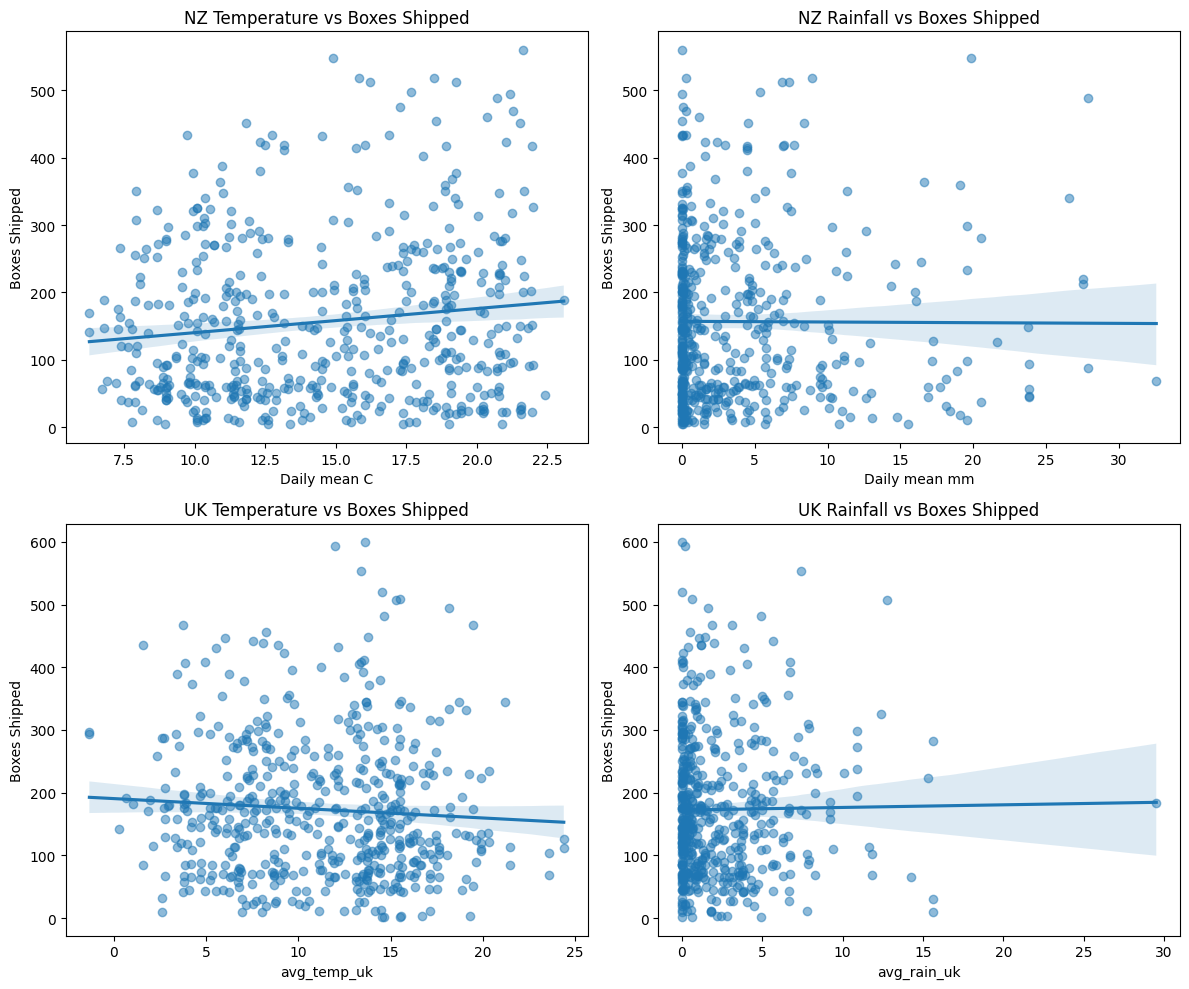

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- NZ Temperature ---
sns.regplot(
    data=nz_weather_sales,
    x='Daily mean C',
    y='Boxes Shipped',
    scatter_kws={'alpha':0.5},
    ax=axes[0, 0]
)
axes[0, 0].set_title('NZ Temperature vs Boxes Shipped')

# --- NZ Rainfall ---
sns.regplot(
    data=nz_weather_sales,
    x='Daily mean mm',
    y='Boxes Shipped',
    scatter_kws={'alpha':0.5},
    ax=axes[0, 1]
)
axes[0, 1].set_title('NZ Rainfall vs Boxes Shipped')

# --- UK Temperature ---
sns.regplot(
    data=uk_weather_sales,
    x='avg_temp_uk',
    y='Boxes Shipped',
    scatter_kws={'alpha':0.5},
    ax=axes[1, 0]
)
axes[1, 0].set_title('UK Temperature vs Boxes Shipped')

# --- UK Rainfall ---
sns.regplot(
    data=uk_weather_sales,
    x='avg_rain_uk',
    y='Boxes Shipped',
    scatter_kws={'alpha':0.5},
    ax=axes[1, 1]
)
axes[1, 1].set_title('UK Rainfall vs Boxes Shipped')

plt.tight_layout()
plt.show()

When analysing the sales by number of boxes, we have an opposite tendency in New Zealand depending on temperature: the warmer, the more chocolate is sold. We can have in mind the cultura differences between the two countries, or also that the hemisphere location plays a role in this inverted tendency.

In [19]:
nz_weather_sales.head(5)

,Date,Daily mean C,Daily mean mm,Sales Person,Country,Product,Amount,Boxes Shipped,Year,Month
10,2022-01-04,20.78,0.00,Dotty Strutley,New Zealand,Choco Coated Almonds,5733.0,348,2022,1
17,2022-01-04,20.78,0.00,Dennison Crosswaite,New Zealand,Organic Choco Syrup,371.0,229,2022,1
22,2022-01-05,19.85,0.00,Gunar Cockshoot,New Zealand,Almond Choco,5173.0,129,2022,1
32,2022-01-10,21.28,0.25,Curtice Advani,New Zealand,Spicy Special Slims,4074.0,469,2022,1
34,2022-01-10,21.28,0.25,Gigi Bohling,New Zealand,Smooth Sliky Salty,700.0,97,2022,1


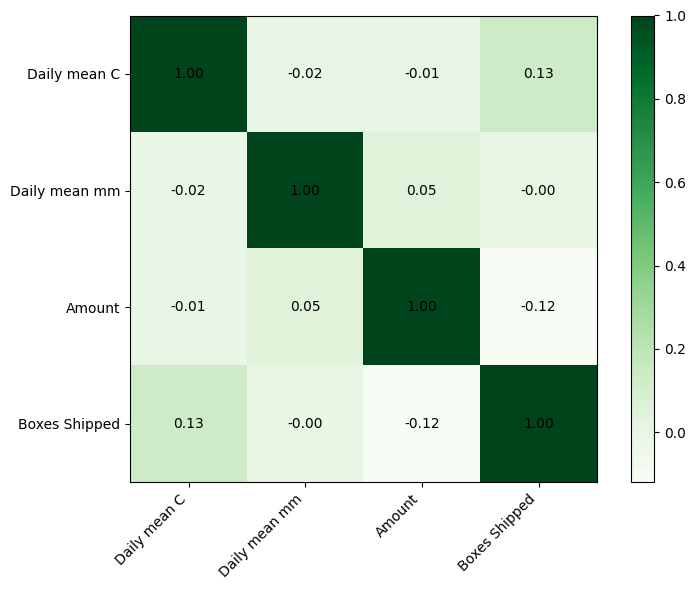

In [20]:
nz_pearson = nz_weather_sales[['Date','Daily mean C','Daily mean mm','Amount','Boxes Shipped']]

pearsoncorr = nz_pearson.corr(method='pearson', numeric_only = True)

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(pearsoncorr, cmap='Greens')

# Add colorbar
fig.colorbar(cax)

# Set tick labels
ax.set_xticks(np.arange(len(pearsoncorr.columns)))
ax.set_yticks(np.arange(len(pearsoncorr.columns)))
ax.set_xticklabels(pearsoncorr.columns, rotation=45, ha='right')
ax.set_yticklabels(pearsoncorr.columns);


# Add annotation text
for i in range(len(pearsoncorr.columns)):
    for j in range(len(pearsoncorr.columns)):
        ax.text(j, i, f"{pearsoncorr.iloc[i, j]:.2f}",
                ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

We only see a slight correlation between temperature and boxes shipped, a positive one, which cannot be explained by our assumption for this country. For the UK:

In [21]:
uk_weather_sales.head(5)

,Date,avg_temp_uk,avg_rain_uk,Sales Person,Country,Product,Amount,Boxes Shipped,Year,Month
1,2022-01-03,7.22,5.26,Camilla Castle,UK,White Choc,9982.0,187,2022,1
2,2022-01-03,7.22,5.26,Dotty Strutley,UK,99% Dark & Pure,9310.0,282,2022,1
5,2022-01-03,7.22,5.26,Ches Bonnell,UK,White Choc,3269.0,226,2022,1
7,2022-01-04,3.00,1.10,Jehu Rudeforth,UK,Mint Chip Choco,5320.0,180,2022,1
23,2022-01-05,1.98,0.00,Madelene Upcott,UK,Fruit & Nut Bars,8512.0,189,2022,1


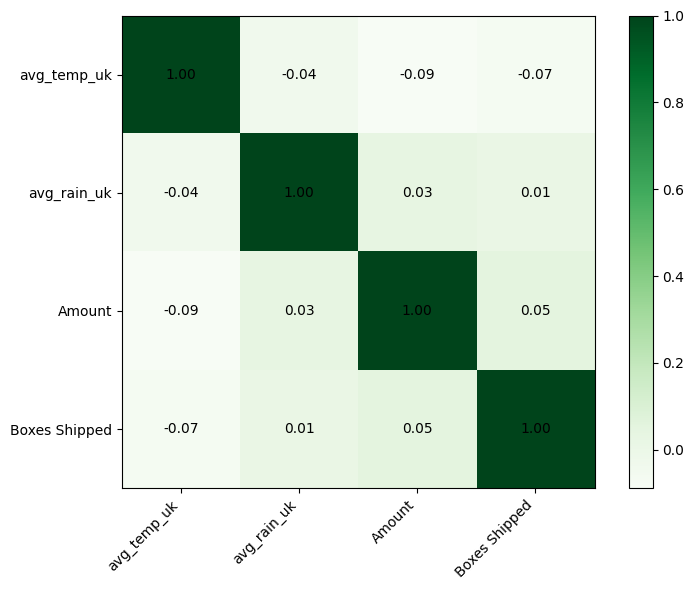

In [22]:
uk_pearson = uk_weather_sales[['Date','avg_temp_uk','avg_rain_uk','Amount','Boxes Shipped']]

pearsoncorr = uk_pearson.corr(method='pearson', numeric_only = True)

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(pearsoncorr, cmap='Greens')

# Add colorbar
fig.colorbar(cax)

# Set tick labels
ax.set_xticks(np.arange(len(pearsoncorr.columns)))
ax.set_yticks(np.arange(len(pearsoncorr.columns)))
ax.set_xticklabels(pearsoncorr.columns, rotation=45, ha='right')
ax.set_yticklabels(pearsoncorr.columns);


# Add annotation text
for i in range(len(pearsoncorr.columns)):
    for j in range(len(pearsoncorr.columns)):
        ax.text(j, i, f"{pearsoncorr.iloc[i, j]:.2f}",
                ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

Here we see an inverted, expected relationship between temperature and boxes shipped/amount in USD. However, the relationship is even weaker than in the case of New Zealand. We cannot determine, based on the available data for sales, that the weather influences dramatically the consumption. There is indeed some correlation in the case of the UK, in the case of NZ other factors should be considered as a direct (positive) relationship temperature/consumption is detected.

## Is chocolate consumption affected by holiday?

What about the other variable in the question? We could think that free days and the festive mood are going to encourage chocolate sales. For this, we are going to compare the national level holidays of four big countries and their consumption of chocolate then. These countries are:

- United States
- India
- Australia
- Canada

In [23]:
# Table of sales is called sales already loaded as dataframe

# Load holidays data

with engine.connect() as conn:
    conn.execute(text(f"SET search_path TO {schema}"))
    holidays_raw = pd.read_sql(
        text("SELECT * FROM jl_holiday_calendar"),
        conn
    )

# Filter out other countries and regional holidays

countries = ["GB","NZ","IN","US","CA","AU",]
holidays_countries = holidays_raw[holidays_raw["Country Code"].isin(countries)].copy()

keep_list = ["National Holiday", "Federal Holiday", "Bank Holiday", "Statutory Holiday", "Public Holiday"]
holidays = holidays_countries[holidays_countries['Type'].isin(keep_list)]

holidays.head(5)

,Country,Country Code,Day,Date,Holiday Name,Type,Comments
5,australia,AU,Monday,2022-04-25,Anzac Day,National Holiday,Restricted trading day
6,new-zealand,NZ,Monday,2022-04-25,Anzac Day,National Holiday,
14,australia,AU,Wednesday,2022-01-26,Australia Day,National Holiday,
51,new-zealand,NZ,Monday,2022-12-26,Boxing Day,National Holiday,
52,united-kingdom,GB,Monday,2022-12-26,Boxing Day,Bank Holiday,


In [24]:
sales['Country'].unique()

array(['UK', 'India', 'Australia', 'New Zealand', 'USA', 'Canada'],
      dtype=object)

/var/folders/48/t16ql6px73b6z62z8gt27g7r0000gn/T/ipykernel_2665/1848245448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays['Date'] = pd.to_datetime(holidays['Date'])


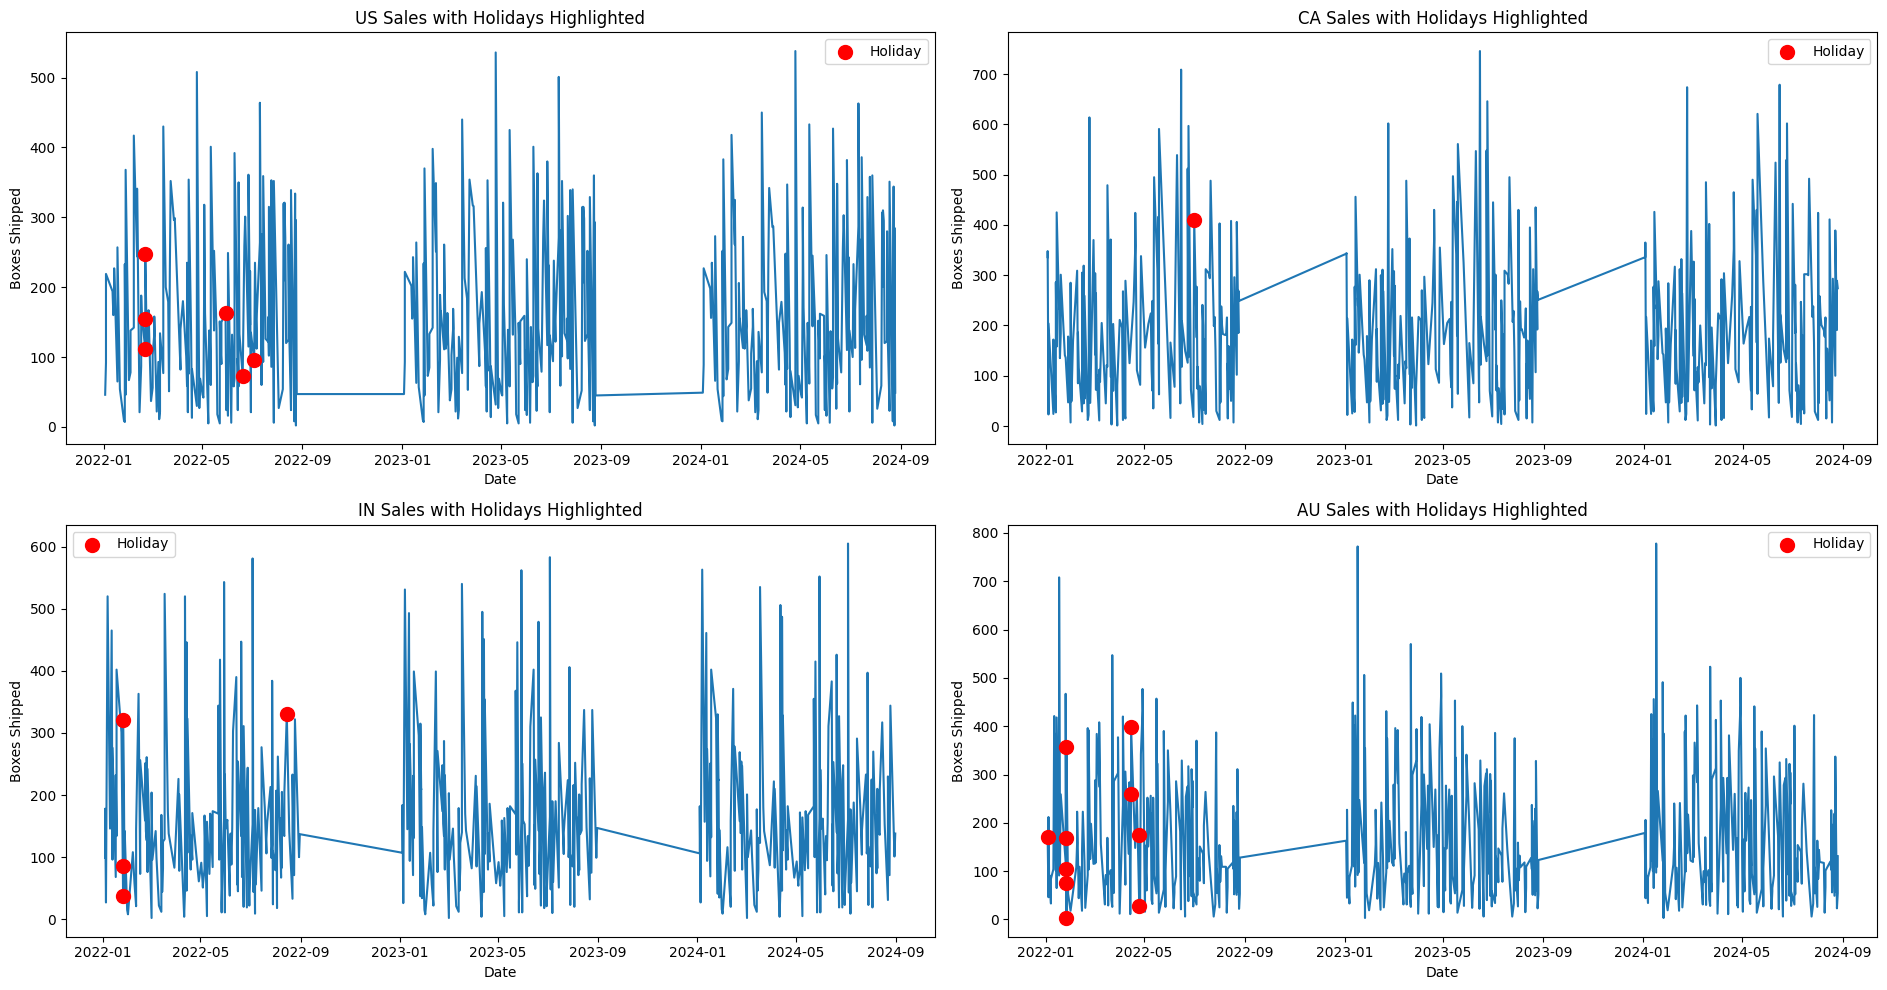

In [25]:
# Plots units (shipped boxes) vs date

# Date format
holidays['Date'] = pd.to_datetime(holidays['Date'])
sales['Date'] = pd.to_datetime(sales['Date'])

us_holidays = holidays[holidays['Country'] == 'US']

fig, axes = plt.subplots(2, 2, figsize=(19, 10))

# =========================
# US
# =========================
ax = axes[0, 0]

us_sales = sales[sales['Country'] == 'USA'].copy()
us_sales['Date'] = pd.to_datetime(us_sales['Date'])

sns.lineplot(
    data=us_sales,
    x='Date',
    y='Boxes Shipped',
    ax=ax,
    estimator = None
)

us_holidays = holidays[holidays['Country Code'] == 'US'].copy()
us_holidays['Date'] = pd.to_datetime(us_holidays['Date'])

us_holiday_data = us_sales[us_sales['Date'].isin(us_holidays['Date'])]

ax.scatter(
    us_holiday_data['Date'],
    us_holiday_data['Boxes Shipped'],
    s=100,
    color='red',
    zorder=3,
    label='Holiday'
)

ax.set_title('US Sales with Holidays Highlighted')
ax.legend()



# =========================
# Canada
# =========================
ax = axes[0, 1]

ca_sales = sales[sales['Country'] == 'Canada'].copy()
ca_sales['Date'] = pd.to_datetime(ca_sales['Date'])

sns.lineplot(
    data=ca_sales,
    x='Date',
    y='Boxes Shipped',
    ax=ax,
    estimator = None
)

ca_holidays = holidays[holidays['Country Code'] == 'CA'].copy()
ca_holidays['Date'] = pd.to_datetime(ca_holidays['Date'])

ca_holiday_data = ca_sales[ca_sales['Date'].isin(ca_holidays['Date'])]

ax.scatter(
    ca_holiday_data['Date'],
    ca_holiday_data['Boxes Shipped'],
    s=100,
    color='red',
    zorder=3,
    label='Holiday'
)

ax.set_title('CA Sales with Holidays Highlighted')
ax.legend()




# =========================
# India
# =========================
ax = axes[1, 0]

in_sales = sales[sales['Country'] == 'India'].copy()
in_sales['Date'] = pd.to_datetime(in_sales['Date'])

sns.lineplot(
    data=in_sales,
    x='Date',
    y='Boxes Shipped',
    ax=ax,
    estimator = None
)

in_holidays = holidays[holidays['Country Code'] == 'IN'].copy()
in_holidays['Date'] = pd.to_datetime(in_holidays['Date'])

in_holiday_data = in_sales[in_sales['Date'].isin(in_holidays['Date'])]

ax.scatter(
    in_holiday_data['Date'],
    in_holiday_data['Boxes Shipped'],
    s=100,
    color='red',
    zorder=3,
    label='Holiday'
)

ax.set_title('IN Sales with Holidays Highlighted')
ax.legend()



# =========================
# Australia
# =========================
ax = axes[1, 1]

au_sales = sales[sales['Country'] == 'Australia'].copy()
au_sales['Date'] = pd.to_datetime(au_sales['Date'])

sns.lineplot(
    data=au_sales,
    x='Date',
    y='Boxes Shipped',
    ax=ax,
    estimator = None
)

au_holidays = holidays[holidays['Country Code'] == 'AU'].copy()
au_holidays['Date'] = pd.to_datetime(au_holidays['Date'])

au_holiday_data = au_sales[au_sales['Date'].isin(au_holidays['Date'])]

ax.scatter(
    au_holiday_data['Date'],
    au_holiday_data['Boxes Shipped'],
    s=100,
    color='red',
    zorder=3,
    label='Holiday'
)

ax.set_title('AU Sales with Holidays Highlighted')
ax.legend()


plt.tight_layout()
plt.show()



/var/folders/48/t16ql6px73b6z62z8gt27g7r0000gn/T/ipykernel_2665/2181924951.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays['Date'] = pd.to_datetime(holidays['Date'])


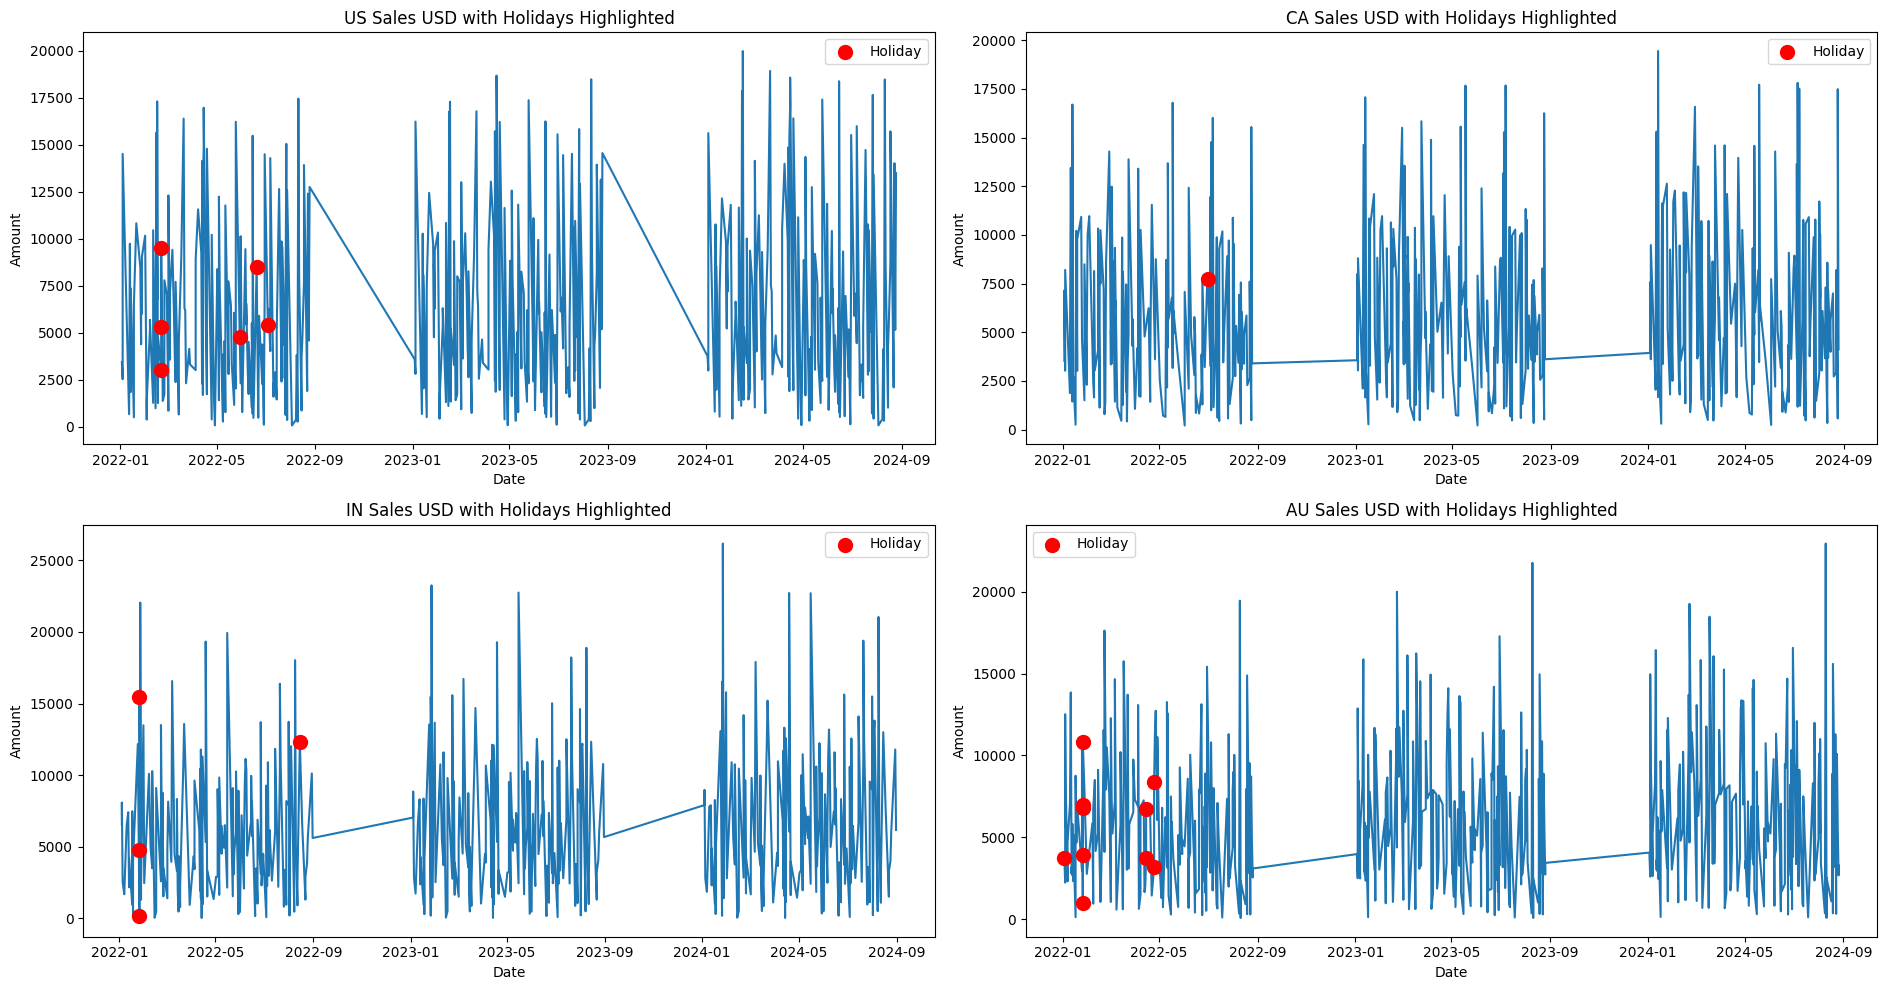

In [26]:
# Plots sales (amount USD) vs date

# Date format
holidays['Date'] = pd.to_datetime(holidays['Date'])
sales['Date'] = pd.to_datetime(sales['Date'])

us_holidays = holidays[holidays['Country'] == 'US']

fig, axes = plt.subplots(2, 2, figsize=(19, 10))

# =========================
# US
# =========================
ax = axes[0, 0]

us_sales = sales[sales['Country'] == 'USA'].copy()
us_sales['Date'] = pd.to_datetime(us_sales['Date'])

sns.lineplot(
    data=us_sales,
    x='Date',
    y='Amount',
    ax=ax,
    estimator = None
)

us_holidays = holidays[holidays['Country Code'] == 'US'].copy()
us_holidays['Date'] = pd.to_datetime(us_holidays['Date'])

us_holiday_data = us_sales[us_sales['Date'].isin(us_holidays['Date'])]

ax.scatter(
    us_holiday_data['Date'],
    us_holiday_data['Amount'],
    s=100,
    color='red',
    zorder=3,
    label='Holiday'
)

ax.set_title('US Sales USD with Holidays Highlighted')
ax.legend()



# =========================
# Canada
# =========================
ax = axes[0, 1]

ca_sales = sales[sales['Country'] == 'Canada'].copy()
ca_sales['Date'] = pd.to_datetime(ca_sales['Date'])

sns.lineplot(
    data=ca_sales,
    x='Date',
    y='Amount',
    ax=ax,
    estimator = None
)

ca_holidays = holidays[holidays['Country Code'] == 'CA'].copy()
ca_holidays['Date'] = pd.to_datetime(ca_holidays['Date'])

ca_holiday_data = ca_sales[ca_sales['Date'].isin(ca_holidays['Date'])]

ax.scatter(
    ca_holiday_data['Date'],
    ca_holiday_data['Amount'],
    s=100,
    color='red',
    zorder=3,
    label='Holiday'
)

ax.set_title('CA Sales USD with Holidays Highlighted')
ax.legend()




# =========================
# India
# =========================
ax = axes[1, 0]

in_sales = sales[sales['Country'] == 'India'].copy()
in_sales['Date'] = pd.to_datetime(in_sales['Date'])

sns.lineplot(
    data=in_sales,
    x='Date',
    y='Amount',
    ax=ax,
    estimator = None
)

in_holidays = holidays[holidays['Country Code'] == 'IN'].copy()
in_holidays['Date'] = pd.to_datetime(in_holidays['Date'])

in_holiday_data = in_sales[in_sales['Date'].isin(in_holidays['Date'])]

ax.scatter(
    in_holiday_data['Date'],
    in_holiday_data['Amount'],
    s=100,
    color='red',
    zorder=3,
    label='Holiday'
)

ax.set_title('IN Sales USD with Holidays Highlighted')
ax.legend()



# =========================
# Australia
# =========================
ax = axes[1, 1]

au_sales = sales[sales['Country'] == 'Australia'].copy()
au_sales['Date'] = pd.to_datetime(au_sales['Date'])

sns.lineplot(
    data=au_sales,
    x='Date',
    y='Amount',
    ax=ax,
    estimator = None
)

au_holidays = holidays[holidays['Country Code'] == 'AU'].copy()
au_holidays['Date'] = pd.to_datetime(au_holidays['Date'])

au_holiday_data = au_sales[au_sales['Date'].isin(au_holidays['Date'])]

ax.scatter(
    au_holiday_data['Date'],
    au_holiday_data['Amount'],
    s=100,
    color='red',
    zorder=3,
    label='Holiday'
)

ax.set_title('AU Sales USD with Holidays Highlighted')
ax.legend()


plt.tight_layout()
plt.show()



- Holidays appear only in the period for 2022 as the retrieved, exact holidays belong to that year.
- We can see the sales are distributed evenly, with no clear seasonality during the year.
- Holidays are arranged in a similar way, without being placed in a peak of sales, or the previous days of that peak of sales as we could expect. 
- Patterns of chocolate sales are similar across the three years, and are not strongly affected by variations in the price of cocoa. Several reasons for this, including possible changes in product composition.

- The data is not supporting the idea that holidays are main drivers of the chocolate sales.